## Midterm BME 502 2025

In this midterm exam, you are tasked to develop a method to tell whether data is better described by a line fit or a sigmoidal fit.

In [1]:
import Pkg
Pkg.activate(".")

  Activating project at `c:\Users\steal\Downloads\Zero2Hero-JuliaWorkshop-main\BME-502-2025-homeworks`


In [2]:
Pkg.add(["Plots","Distributions","Random","Statistics","NonlinearSolve","ForwardDiff"])

   Resolving package versions...
  No Changes to `C:\Users\steal\Downloads\Zero2Hero-JuliaWorkshop-main\BME-502-2025-homeworks\Project.toml`
  No Changes to `C:\Users\steal\Downloads\Zero2Hero-JuliaWorkshop-main\BME-502-2025-homeworks\Manifest.toml`


In [2]:
using Plots, Distributions, Random, Statistics, NonlinearSolve, ForwardDiff, LinearAlgebra

In [5]:
line_fit(x,p) = p[1] .+ p[2] .* x

line_fit (generic function with 1 method)

In [6]:
sigmoid_fit(x,p) = p[1] .+ p[2] ./ (1 .+ exp.(-p[3]*(x .- p[4])))

sigmoid_fit (generic function with 1 method)

Let's create some plots to see how these functions look

In [8]:
x = 0:0.1:10

0.0:0.1:10.0

In [9]:
y_line = line_fit(x,[2,0.5])

2.0:0.05:7.0

In [10]:
y_sigmoid = sigmoid_fit(x,[2.5,3.5,0.1,5.5])

2.5:0.35:37.5

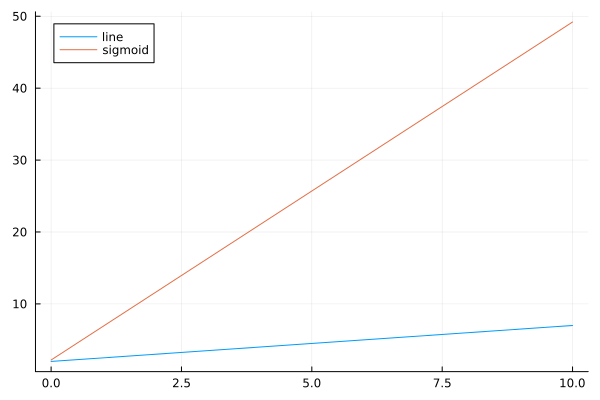

In [11]:
y_line = line_fit(x,[2,0.5])
y_sigmoid = sigmoid_fit(x,[2.2,4.7,1,5.0])
plot(x, y_line, label = "line")
plot!(x, y_sigmoid, label = "sigmoid")

Let us add some serious noise to it

In [12]:
nd = Normal(0,5)
x_line = 10*rand(200)
y_line_n = line_fit(x_line,[2,0.5]) .+ rand(nd,length(x_line))
x_sigmoid = 10*rand(200)
y_sigmoid_n = sigmoid_fit(x_sigmoid,[2.2,4.7,1,5.0]) .+ rand(nd,length(x_sigmoid))

200-element Vector{Float64}:
 34.40608870260491
 19.000553234457577
 42.080121634612055
  6.045814537993186
 13.829223888858023
 47.86014862695715
 20.659076129647374
 31.989052696018952
 43.216874307263396
 13.201322650456317
  ⋮
 23.96090039924142
 30.61642135399239
  3.010428665694632
  0.849694997785674
 39.162620450884525
  1.0932582182743884
 12.571062643205666
 15.05777114344279
 11.391941572742354

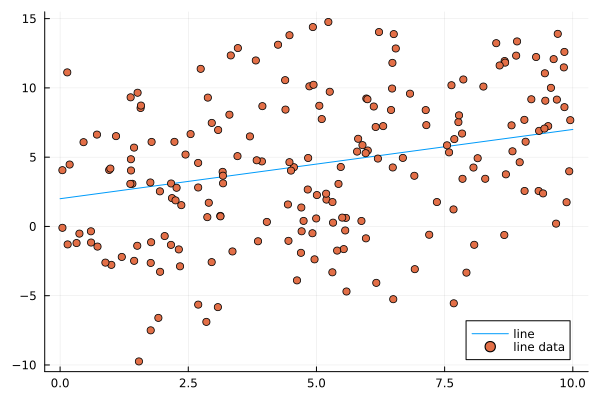

In [13]:
plot(x, y_line, label = "line")
scatter!(x_line, y_line_n, label = "line data")

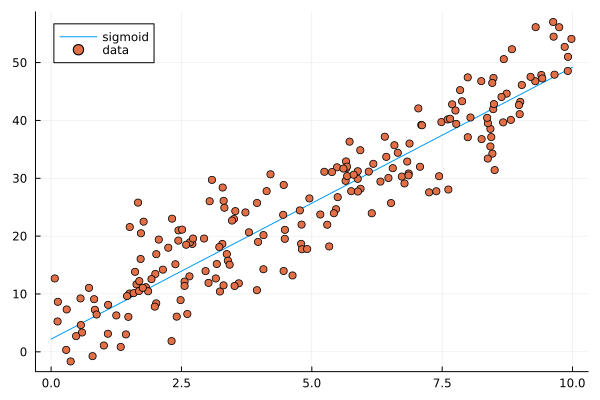

In [14]:
plot(x, y_sigmoid, label = "sigmoid")
scatter!(x_sigmoid, y_sigmoid_n, label = "data")

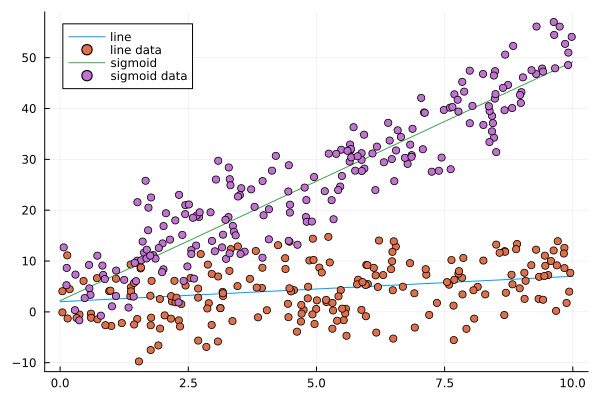

In [15]:
# let's plot it all together
plot(x, y_line, label = "line")
scatter!(x_line, y_line_n, label = "line data")
plot!(x, y_sigmoid, label = "sigmoid")
scatter!(x_sigmoid, y_sigmoid_n, label = "sigmoid data")

# Question:

If you take the sigmoid data, which fit is better? The linear or sigmoid?

How uncertain are the parameters?

At what noise level are the two fits equally likely?

# Part 1 (20 points)
Create a function line_fitting(x,y; sigma=[]) that returns the best parameters and the covariance matrix.  The standard deviation of the measurement error, sigma, can be supplied as a number (assuming that all measurements share the same error) or as a vector with the same length as y. If sigma (standard deviation of measurement error) is not specified (sigma=[]), estimate the measurement error using the sum of least squares to estimate $\mathcal{X}^2$.

In [32]:
function res(u, (x,y))
    return u[1] .* exp.( -u[2] .* x) .- y
end

res (generic function with 1 method)

In [30]:
using Plots, Distributions, Random, Statistics, NonlinearSolve, ForwardDiff, LinearAlgebra, LsqFit

line_fit(x,p) = p[1] .+ p[2] .* x

function line_fitting(x, y, σ)
    
    p0 = [0.0, 1.0]  # Starting guesses for intercept and slope

    fit = curve_fit(line_fit, x, y_line, p0)
    
    # Retrieve BEST parameters
    fit.param
    
    # What if σ = []?
    if σ == []
        #Get N and M values to find degrees of freedom
        N = length(y)
        M = length(fit)

        dof = (N .- M)

        chi2 = sum(res(u, (x, y)) .^ 2 ./ dof.^2)
        h = ForwardDiff.hessian(chi2, fit.param)
        sqrt.(inv(2*h))
    else
        chi2(p) = sum(res(u, (x, y)) .^ 2 ./ σ.^2)
        h = ForwardDiff.hessian(chi2, fit.param)
        sqrt.(inv(2*h))
    end
    
    return fit.param, inv(2*ForwardDiff.hessian(chi2, fit.param)), chi2(fit.param)
end

line_fitting (generic function with 1 method)

In [33]:
x = 0:0.1:10
p = [2.0, 1.0]
y_exp = p[1] .* x .+ p[2] .+ 0.1 .* randn(length(x))
σ = 0.1 .* randn(length(x))
line_fitting(x, y, σ)

CanonicalIndexError: CanonicalIndexError: setindex! not defined for StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}

# Part 2 (20 points)
Similarily, create a function sigmoid_fitting(x,y; sigma=[]) that returns the best parameters and the covariance matrix. Treat sigma the same way as in Part 1.

In [5]:
using Plots, Distributions, Random, Statistics, NonlinearSolve, ForwardDiff, LinearAlgebra, LsqFit

sigmoid_fit(x,p) = p[1] .+ p[2] .* x

function sigmoid_fitting(x, y, σ)
    
    fit = curve_fit(sigmoid_fit, x, y)
    
    # Retrieve BEST parameters
    fit.param

    #Need chi2 values
    chi2(p) = sum(res(u, (x, y)) .^ 2 ./ σ.^2)

    # What if σ = []?
    if σ == []
        #Get N and M values to find degrees of freedom
        N = length(y)
        M = length(fit)

        dof = (N .- M)

        chi2 = sum(res(u, (x, y)) .^ 2 ./ dof.^2)
        h = ForwardDiff.hessian(chi2, fit.param)
        sqrt.(inv(2*h))
    end
    
    return fit.param, inv(2*ForwardDiff.hessian(chi2, fit.param)), chi2(fit.param)
end

sigmoid_fitting (generic function with 1 method)

# Part 3 (30 points)
Create a function p_ratio_sig_line(x,y; sigma=[]) that returns the Posterior ratio between a fit to a sigmoid and to a line.  Treat sigma the same way as in Part 1-2.

In [ ]:
function p_ratio_sig_line(x, y, σ)


    # What if σ = []?
    if σ == []
        σ = sqrt(sum(res(u, (x, y)) .^ 2) / length(y))  # Estimate sigma using sum of squared residuals
        chi2 = sum(res(u, (x, y)) .^ 2 ./ σ^2)  # Recalculate chi2 using estimated sigma
    end
end

# Part 4 (30 points)
Create a function sig_p_ratio_is_one(x,y; sigma=[]) that returns the measurement error (either as a number or array depending on how the sigma is supplied) that would result in a posterior ratio between sigmoid and line of one. If sigma is not provided (sigma=[]), proceed as in Part 1-3.

## Programming Advice:
To make your program more efficient you should think about creating functions that provide information that you can use for all of the parts.  Don't write each function individually, but think what are the common task that need to be done, and then call these more general functions, to get you the result for the specific questions.  I will reward good programming style with a bonus 10 points total.